In [1]:
!pip install keras



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import joblib 
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import librosa
import glob
#from keras.utils import np_utils
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Activation, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, classification_report
from tensorflow.keras import backend
#import tensorflow_addons as tfa
from tensorflow.keras.metrics import Recall

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [4]:
DIR= './input/ravdess'

In [5]:
def extract_features(file_name, mfcc, chroma, mel):
    X, sample_rate= librosa.load(os.path.join(file_name), res_type= 'kaiser_fast')
    if chroma:
        stft= np.abs(librosa.stft(X))
    result= np.array([])
    if mfcc:
        mfcc= np.mean(librosa.feature.mfcc(y=X, sr= sample_rate, n_mfcc= 40).T, axis=0)
        result= np.hstack((result, mfcc))
    if chroma:
        chroma= np.mean(librosa.feature.chroma_stft(S= stft, sr= sample_rate).T, axis=0)
        result= np.hstack((result, chroma))
    if mel:
        mel= np.mean(librosa.feature.melspectrogram(y=X, sr= sample_rate).T, axis=0)
        result= np.hstack((result, mel))
    return result

In [6]:
def test_data():
    x= []

    file1= '../input/ravdess/help me.wav'
    file2= '../input/ravdess/t1.wav'
    features= extract_features(file1, mfcc= True, chroma= True, mel= True)
    x.append(features)
    features= extract_features(file2, mfcc= True, chroma= True, mel= True)
    x.append(features)
    return x

In [7]:
test= np.array(test_data())
testcnn= np.expand_dims(test, axis=2)

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
features_DIR= '/Users/hp/Documents/SafeToday/SafeToday-server/acoustic_features.joblib'
labels_DIR= '/Users/hp/Documents/SafeToday/SafeToday-server/labels.joblib'
x, y = joblib.load(features_DIR), joblib.load(labels_DIR)
x= np.array(x)
le= LabelEncoder()
y = le.fit_transform(y)  # Label encode the target labels

# One-hot encode the labels using TensorFlow's to_categorical
y = to_categorical(y)
#y= np_utils.to_categorical(le.fit_transform(y))
# ohe= OneHotEncoder()
# y= ohe.fit_transform(y.reshape(-1,1))
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,  random_state= 42, shuffle= True)

In [9]:
x_train.shape

(1500, 180)

In [10]:
#DataFlair - Initialize the Multi Layer Perceptron Classifier
MPLC = MLPClassifier(alpha=0.001, 
                    batch_size=256, 
                    epsilon=1e-08, 
                    hidden_layer_sizes=(300,), 
                    learning_rate='adaptive', 
                    max_iter=1000)

In [11]:
MPLC.fit(x_train, y_train)

MLPClassifier(alpha=0.001, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=1000)

In [12]:
#joblib.dump(MPLC, 'MPLC.h5')
MPLC.score(x_test, y_test)

0.668

In [13]:
list(le.classes_)

['female_angry',
 'female_calm',
 'female_fearful',
 'female_happy',
 'female_sad',
 'male_angry',
 'male_calm',
 'male_fearful',
 'male_happy',
 'male_sad']

In [14]:
b= MPLC.predict_proba(test)

In [15]:
classification_report(y_test, MPLC.predict(x_test))

/Users/hp/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.94      0.82      0.88        79\n           1       0.73      0.73      0.73        22\n           2       0.90      0.86      0.88        73\n           3       0.93      0.83      0.88        82\n           4       0.90      0.83      0.86        72\n           5       0.68      0.54      0.60        35\n           6       1.00      0.43      0.60        30\n           7       0.47      0.64      0.54        36\n           8       0.83      0.50      0.62        38\n           9       0.53      0.70      0.61        33\n\n   micro avg       0.81      0.74      0.77       500\n   macro avg       0.79      0.69      0.72       500\nweighted avg       0.83      0.74      0.77       500\n samples avg       0.70      0.74      0.71       500\n'

In [16]:
svc= SVC()
svc.probability=True

In [17]:
svc.fit(x_train, np.argmax(y_train, axis= 1))

SVC(probability=True)

In [18]:
svc.score(x_test, np.argmax(y_test, axis=1))

0.554

In [19]:
a= svc.predict_proba(test)

In [20]:
#joblib.dump(svc, 'svc.h5')

In [21]:
c= a+b

In [22]:
np.argmax(c, axis=1)

array([2, 1])

In [23]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_classifier.fit(x_train, np.argmax(y_train, axis= 1))
rf_score = rf_classifier.score(x_test, np.argmax(y_test, axis=1))
print(f"Random Forest Classifier Score: {rf_score}")

Random Forest Classifier Score: 0.798


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94        79
           1       0.65      0.91      0.75        22
           2       0.81      0.88      0.84        73
           3       0.91      0.83      0.87        82
           4       0.81      0.79      0.80        72
           5       0.79      0.66      0.72        35
           6       0.67      0.87      0.75        30
           7       0.65      0.61      0.63        36
           8       0.63      0.71      0.67        38
           9       0.80      0.61      0.69        33

    accuracy                           0.80       500
   macro avg       0.77      0.78      0.77       500
weighted avg       0.81      0.80      0.80       500



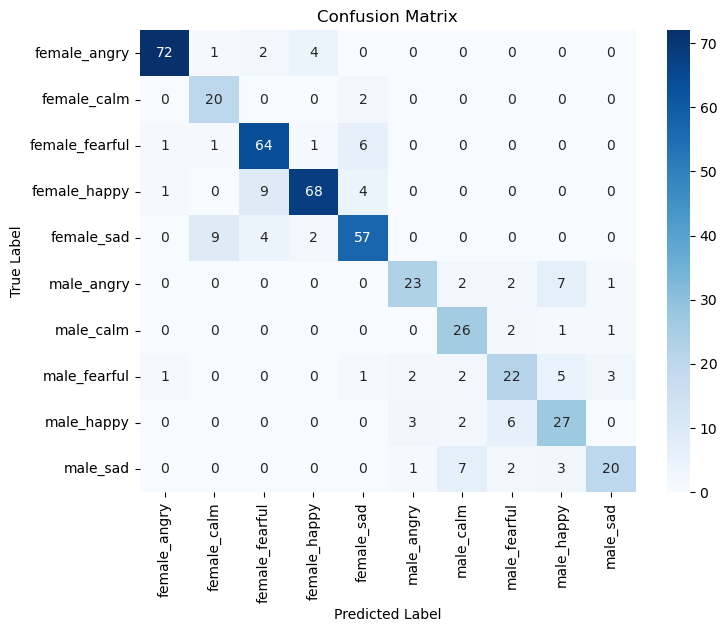

Accuracy: 0.798


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = rf_classifier.predict(x_test)

# Evaluate using classification report
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=1), y_pred))

# Evaluate using confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# You can also print the accuracy score explicitly
print(f"Accuracy: {rf_score}")


In [33]:
joblib.dump(rf_classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [24]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs', random_state=42)
log_reg.fit(x_train, np.argmax(y_train, axis=1))

# Save the model
joblib.dump(log_reg, 'LogisticRegression.joblib')

# Evaluate the model
score = log_reg.score(x_test, np.argmax(y_test, axis=1))
print("Accuracy: ", score)


/Users/hp/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.764


In [25]:
pip install xgboost



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import xgboost as xgb

testcnn_reshaped = testcnn.reshape(testcnn.shape[0], -1)  # Flatten the array to 2D

train_data = xgb.DMatrix(x_train, label=np.argmax(y_train, axis=1))
test_data = xgb.DMatrix(x_test, label=np.argmax(y_test, axis=1))

# Define the XGBoost parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': y_train.shape[1], # Number of classes
    'eval_metric': 'mlogloss',     # Multi-class log loss
    'max_depth': 6,                # Depth of the trees
    'eta': 0.1,                    # Learning rate
    'subsample': 0.8,              # Subsampling ratio
    'colsample_bytree': 0.8        # Column sampling ratio
}

# Train the XGBoost model
num_round = 100  # Number of boosting rounds
model = xgb.train(params, train_data, num_round)

# Make predictions on the test set
y_pred = model.predict(test_data)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Save the model
#model.save_model('xgboost_model.json')

# Optionally, make predictions on custom test data (if any)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94        79
           1       0.67      0.91      0.77        22
           2       0.79      0.84      0.81        73
           3       0.89      0.85      0.87        82
           4       0.87      0.81      0.83        72
           5       0.76      0.71      0.74        35
           6       0.83      0.80      0.81        30
           7       0.64      0.64      0.64        36
           8       0.75      0.71      0.73        38
           9       0.68      0.79      0.73        33

    accuracy                           0.81       500
   macro avg       0.78      0.80      0.79       500
weighted avg       0.82      0.81      0.81       500



Confusion Matrix:


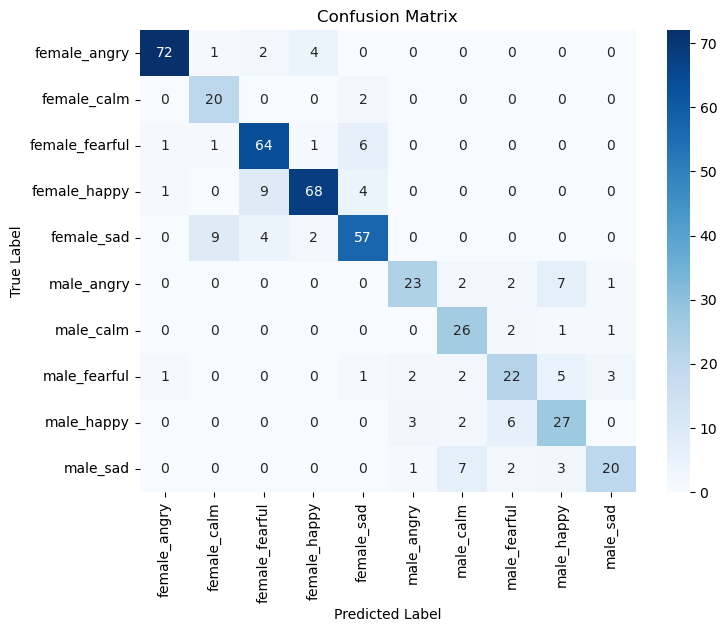

In [35]:
# Confusion Matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print("Confusion Matrix:")

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [36]:
joblib.dump(model, 'xgboost_model.pkl')

['xgboost_model.pkl']